# Задание для курсового проекта

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение моделей машинного обучения из библиотеки sklearn.

# Курсовой проект

## Подключение библиотек

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
%matplotlib inline

## Считывание данных

In [2]:
test_data = pd.read_csv("test.csv")
train_data = pd.read_csv("train.csv")

## Функции обработки данных и построения модели

### Функция получения основных сведений о датасете

In [3]:
def get_data_info(data, label):  
    print(f"############## Head for {label} ##############")
    print(data.head())
    print()
    
    print(f"############## Describe for {label} ##############")
    print(data.describe())
    print()
    
    # Проверяем признаки на наличие null значений
    print(f"############## Check {label} for null values ##############")
    print(data.isnull().sum())
    print()
    
    # Проверяем все ли признаки находятся в числовом формате
    print(f"############## Check {label} for features types ##############")
    print(data.dtypes)
    print()
    
    # Проверяем множество значений нечисловых признаков
    print(f"############## Check {label} non-numeric fetures for unique values ##############")
    print(f"Ecology_2 unique values: {data.Ecology_2.unique()}")
    print(f"Ecology_3 unique values: {data.Ecology_3.unique()}")
    print(f"Shops_2 unique values: {data.Shops_2.unique()}")
    print()

### Функция замены нечисловых значений на числовые

In [4]:
def handle_non_numeric_features(data):
    columns = ["Ecology_2", "Ecology_3", "Shops_2"]
    for column in columns:
        data.loc[data[column] == "A", column] = 0
        data.loc[data[column] == "B", column] = 1
    return data

### Функция восстанавления null значений
* В выборках присутствует большое число null значений в признаках LifeSquare и Healthcare_1 (25-40% приблизительно). Это значение слишком велико, чтобы исключить строки с null значениями из итоговой выборки, и слишком маленькое, чтобы исключить эти столбцы целиком, поэтому эти значения нужно восстановить. 

In [5]:
def handle_null_features(data):
    columns = ["LifeSquare", "Healthcare_1"]
    for column in columns:
        data[column] = data[column].replace(np.nan, data[column].mean())
    return data

### Функция замены количества комнат для квартир, у которых изначальное количесто комнат равно 0.

In [6]:
def handle_wrong_rooms_number_features(data):
    data.loc[(data['Rooms'] == 0.0) & (data['Square'] > 20), 'Rooms'] = data['Square'] // 20
    data.loc[(data['Rooms'] == 0.0) & (data['Square'] < 20), 'Rooms'] = 1
    return data

### Функция изменения данных о площади (общей, жилой и кухни) для квартир

In [7]:
def handle_wrong_square_features(data):
    data.loc[data["Square"] < 22.5, "Square"] = 22.5
    data.loc[(data['Square'] - data['LifeSquare'] <= 0) | (data["LifeSquare"] < 15), "LifeSquare"] = data["Square"] * 0.8
    data.loc[(data['KitchenSquare'] / data['Square'] > 0.5) | (data["KitchenSquare"] < 3), "KitchenSquare"] = data["Square"] * 0.15
    return data

### Функция замены даты постройки дома для квартир с некорректной датой

In [8]:
def handle_wrong_house_year_features(data):
    data.loc[data["HouseYear"] > 2020, "HouseYear"] = 2020
    return data

### Функция изменения данных об этажах квартир и дома
* Необходима для квартир, у которых номер этажа больше этажности дома

In [9]:
def handle_wrong_floor_features(data):
    data.loc[(data['HouseFloor'] - data['Floor'] < 0) | (data['HouseFloor'] < 1), 'HouseFloor'] = data['Floor']
    return data

### Функция подсчета корреляции и построения корреляционной матрицы

In [10]:
def get_correlation_heatmap(data, label):
    corr_mat = data.corr(method='pearson')
    plt.figure(figsize = (30, 15))
    sns.heatmap(corr_mat,vmax=1,square=True,annot=True,cmap='cubehelix')

### Функция построения графика распределения значений признаков

In [11]:
def get_distribution(data):
    for feature in data.columns:
        plt.figure(figsize = (10, 5))
        data[feature].hist(bins=50)
        plt.ylabel('Count')
        plt.xlabel(feature)
        plt.title(f'{feature} distribution')
        plt.show()

### Функция первичной обработки данных

In [12]:
def prepare_data(data):
    data = handle_non_numeric_features(data)
    data = handle_null_features(data)
    data = handle_wrong_rooms_number_features(data)
    data = handle_wrong_square_features(data)
    data = handle_wrong_house_year_features(data)
    data = handle_wrong_floor_features(data)
    return data

### Функции обучения модели и оценки точности результатов

In [13]:
def estimate_model(data, model):
    y = data['Price']
    X = data.drop("Price", axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    check_test_train = pd.DataFrame({
        "y_train": y_train.ravel(),
        "y_pred": y_pred_train.flatten(),
    })
    
    y_pred = model.predict(X_test)
    check_test = pd.DataFrame({
        "y_test": y_test.ravel(),
        "y_pred": y_pred.flatten(),
    })
    
    R2_train = r2_score(check_test_train["y_pred"], check_test_train["y_train"])
    print("Значение R2 для тренировочных данных: ", R2_train)
    
    R2 = r2_score(check_test["y_pred"], check_test["y_test"])
    print("Значение R2 для тестовых данных: ", R2)
    
    print(R2 / R2_train)
    
    return model

In [14]:
def estimate_gradient_boosting(data):
    model = GradientBoostingRegressor(n_estimators=400, loss="huber",  random_state=42)
    return estimate_model(data, model)

## Обработка данных

### Получение информации о датасетах

In [15]:
get_data_info(train_data, "train_data")
get_data_info(test_data, "test_data")

############## Head for train_data ##############
      Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038          35    2.0  47.981561   29.442751            6.0      7   
1  15053          41    3.0  65.683640   40.049543            8.0      7   
2   4765          53    2.0  44.947953   29.197612            0.0      8   
3   5809          58    2.0  53.352981   52.731512            9.0      8   
4  10783          99    1.0  39.649192   23.776169            7.0     11   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0         9.0       1969   0.089040         B         B        33      7976   
1         9.0       1978   0.000070         B         B        46     10309   
2        12.0       1968   0.049637         B         B        34      7759   
3        17.0       1977   0.437885         B         B        23      5735   
4        12.0       1976   0.012339         B         B        35      5776   

   Social_3  Healt

max      23.000000  

############## Check test_data for null values ##############
Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

############## Check test_data for features types ##############
Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        

### Выявленные проблемы с данными:
* 1. Недостаток данных (пропущенные значения в полях "LifeSquare" и "Healthcare_1"
* 2. Этаж квартиры больше этажности дома.
* 3. Некорректный год постройки дома
* 4. Максимальная жилая площадь и максимальная площадь кухни больше, чем максимальная площадь дома
* 5. Слишком маленькие значения общей площади, жилой площади и площади кухни
* 6. Количество этажей в дома равно 0

## Построение графиков распределений значений признаков

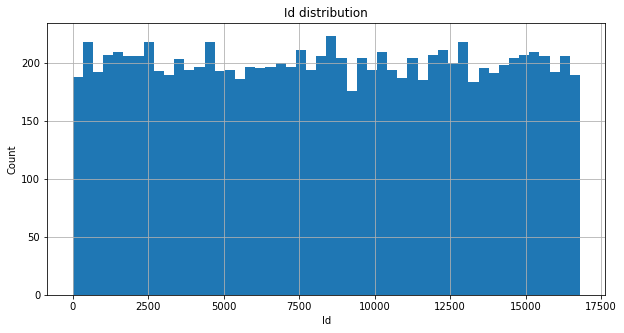

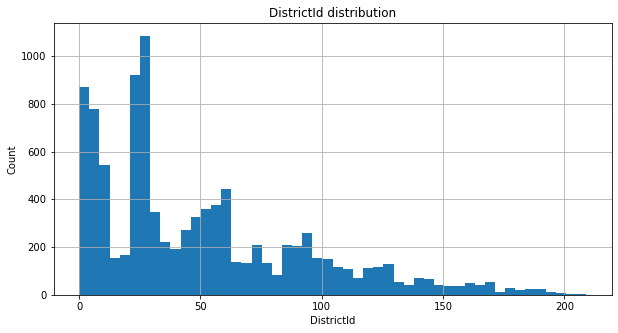

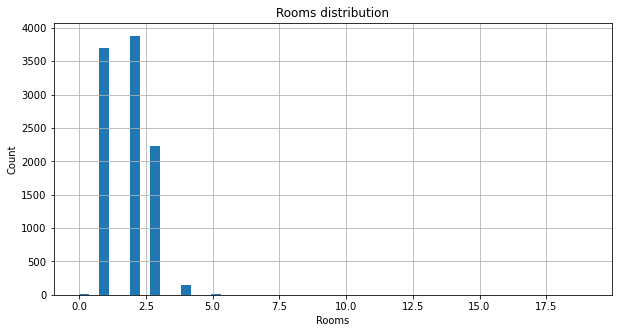

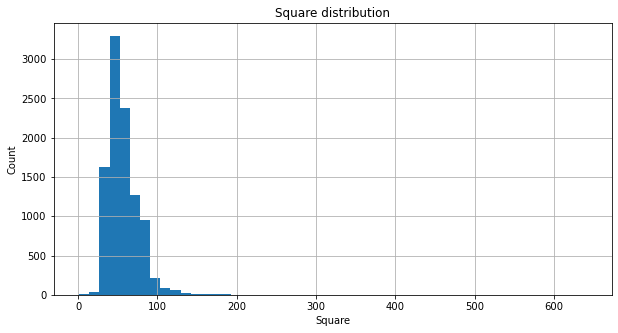

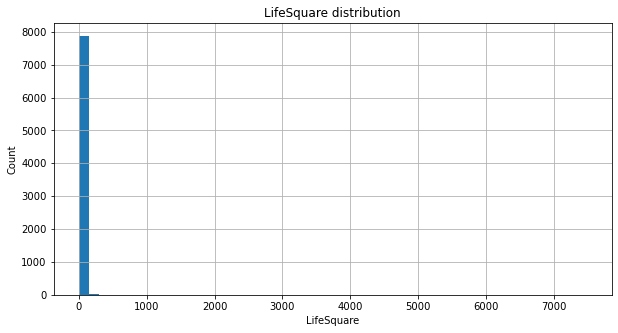

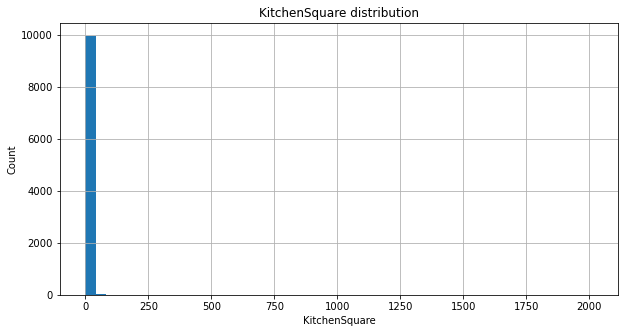

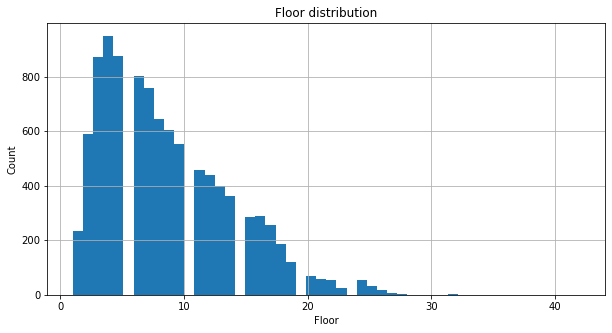

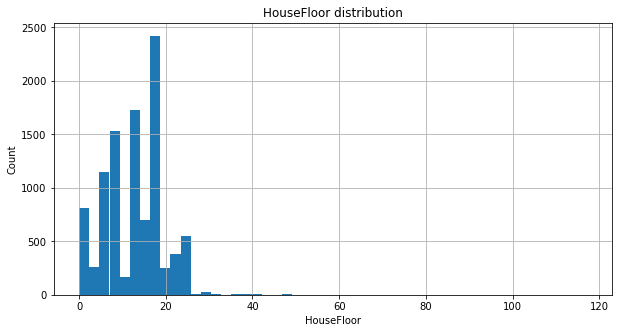

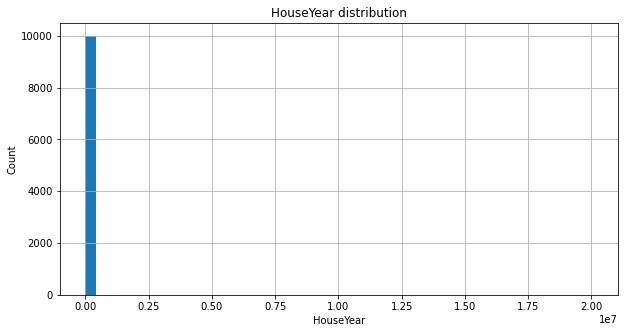

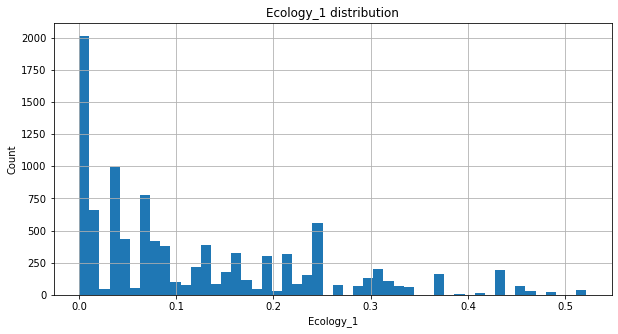

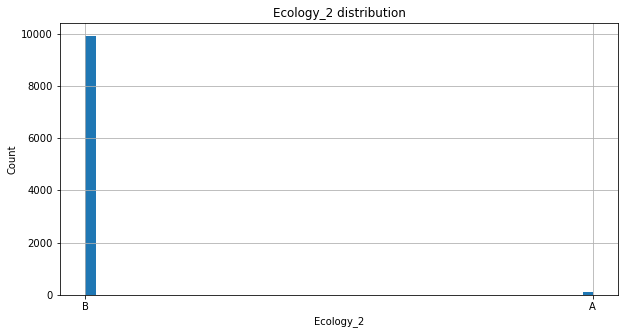

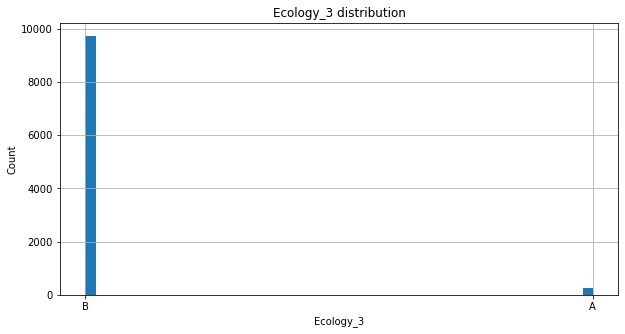

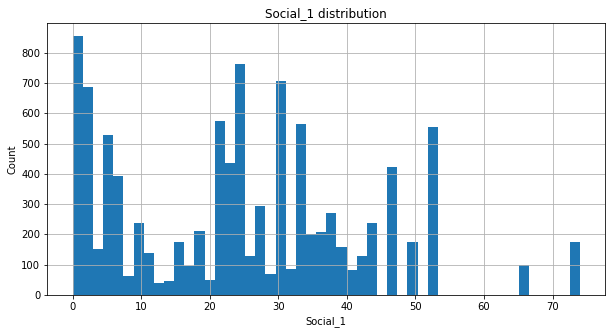

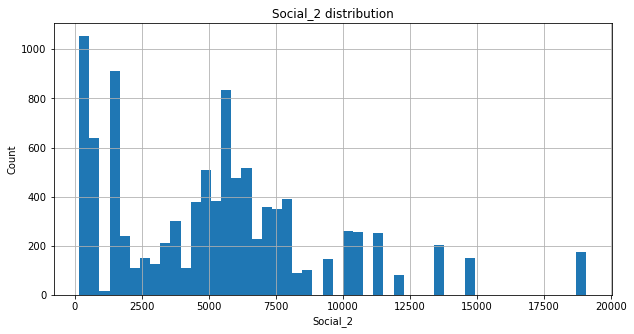

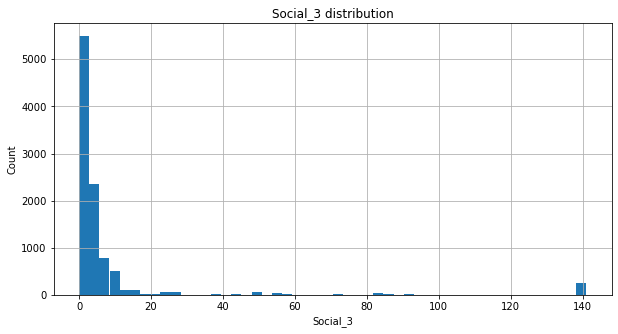

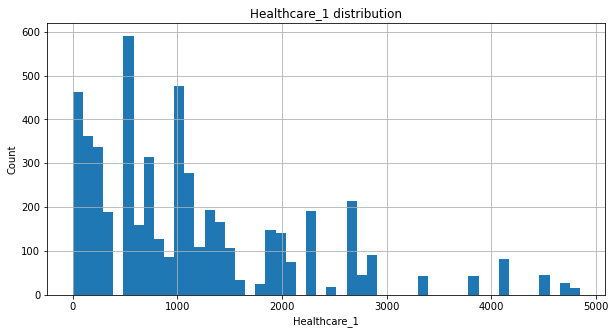

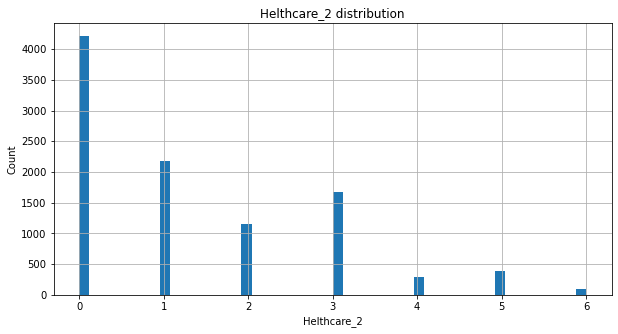

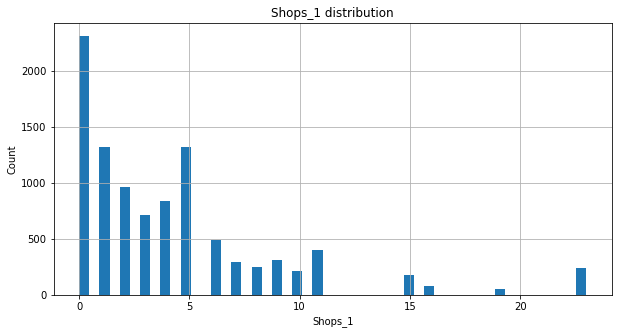

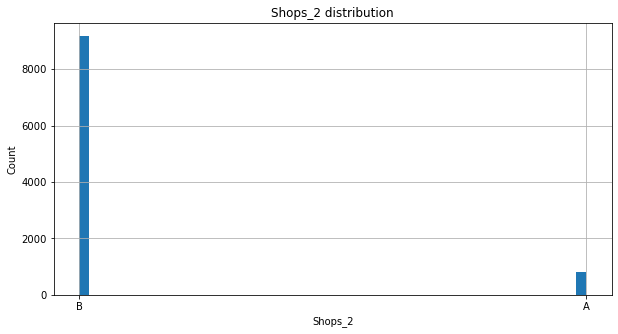

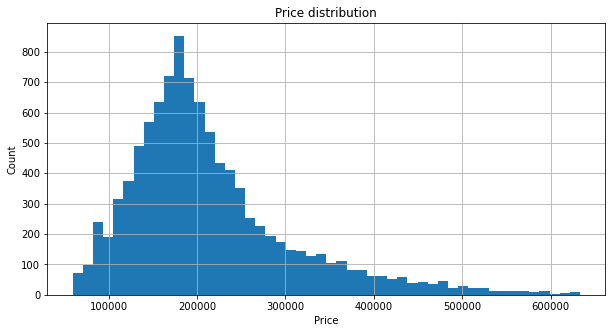

In [16]:
get_distribution(train_data)

## Подготовка данных для построения модели

In [17]:
train_data = prepare_data(train_data)
test_data = prepare_data(test_data)

# Добавление признака MeanHouseFloorDistrictIdPrice
mean_housefloor_districtid_price = train_data\
        .groupby(["HouseFloor", "Floor", "DistrictId"], as_index=False)\
        .agg({"Price": "mean"})\
        .rename(columns={"Price": "MeanHouseFloorDistrictIdPrice"})

train_data = train_data.merge(mean_housefloor_districtid_price, on=["HouseFloor", "Floor", "DistrictId"], how='left')
test_data = test_data.merge(mean_housefloor_districtid_price, on=["HouseFloor", "Floor", "DistrictId"], how='left')
test_data["MeanHouseFloorDistrictIdPrice"] = test_data["MeanHouseFloorDistrictIdPrice"].replace(np.nan, test_data["MeanHouseFloorDistrictIdPrice"].mean())

# Добавление признака SquareType
train_data["SquareType"] = train_data["Square"] // 40
test_data["SquareType"] = test_data["Square"] // 40

# Добавление признака MeanSquareTypeDistrictIdPrice
mean_squaretype_districtid_price = train_data\
        .groupby(["SquareType", "DistrictId"], as_index=False)\
        .agg({"Price": "mean"})\
        .rename(columns={"Price": "MeanSquareTypeDistrictIdPrice"})

train_data = train_data.merge(mean_squaretype_districtid_price, on=["SquareType", "DistrictId"], how='left')
test_data = test_data.merge(mean_squaretype_districtid_price, on=["SquareType", "DistrictId"], how='left')
test_data["MeanSquareTypeDistrictIdPrice"] = test_data["MeanSquareTypeDistrictIdPrice"].replace(np.nan, test_data["MeanSquareTypeDistrictIdPrice"].mean())

# Добавление признака MeanHouseYearPrice
mean_houseyear_price = train_data\
        .groupby(["HouseYear", "DistrictId"], as_index=False)\
        .agg({"Price": "mean"})\
        .rename(columns={"Price": "MeanHouseYearPrice"})

train_data = train_data.merge(mean_houseyear_price, on=["HouseYear", "DistrictId"], how='left')
test_data = test_data.merge(mean_houseyear_price, on=["HouseYear", "DistrictId"], how='left')
test_data["MeanHouseYearPrice"] = test_data["MeanHouseYearPrice"].replace(np.nan, test_data["MeanHouseYearPrice"].mean())

# Добавление признаков MeanDistrictPrice, MeanDistrictSquare, MeanDistrictPricePerSquare
mean_district_square_price = train_data\
        .groupby("DistrictId", as_index=False)\
        .agg({"Square": "mean", "Price": "mean"})\
        .rename(columns={'Square':'MeanDistrictSquare', "Price": "MeanDistrictPrice"})

train_data = train_data.merge(mean_district_square_price, on="DistrictId", how='left')
train_data["MeanDistrictPricePerSquare"] = train_data["MeanDistrictPrice"] / train_data["MeanDistrictSquare"]

test_data = test_data.merge(mean_district_square_price, on="DistrictId", how='left')
test_data["MeanDistrictPricePerSquare"] = test_data["MeanDistrictPrice"] / test_data["MeanDistrictSquare"]

test_data["MeanDistrictPrice"] = test_data["MeanDistrictPrice"].replace(np.nan, test_data["MeanDistrictPrice"].mean())
test_data["MeanDistrictSquare"] = test_data["MeanDistrictSquare"].replace(np.nan, test_data["MeanDistrictSquare"].mean())
test_data["MeanDistrictPricePerSquare"] = test_data["MeanDistrictPricePerSquare"].replace(np.nan, test_data["MeanDistrictPricePerSquare"].mean())

# Добавление признака MeanPriceSocial
mean_price_by_social = train_data.groupby(['Social_1', 'Social_2', 'DistrictId'], as_index=False).agg({'Price':'mean'})\
                       .rename(columns={'Price':'MeanPriceSocial'})
train_data = train_data.merge(mean_price_by_social, on=['Social_1', 'Social_2', 'DistrictId'], how='left')
test_data = test_data.merge(mean_price_by_social, on=['Social_1', 'Social_2', 'DistrictId'], how='left')
test_data["MeanPriceSocial"] = test_data["MeanPriceSocial"].replace(np.nan, test_data["MeanPriceSocial"].mean())

# Добавление признака MeanPriceByDistrict
mean_price_by_district = train_data.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'mean'})\
                       .rename(columns={'Price':'MeanPriceByDistrict'})
train_data = train_data.merge(mean_price_by_district, on=['DistrictId', 'Rooms'], how='left')
test_data = test_data.merge(mean_price_by_district, on=['DistrictId', 'Rooms'], how='left')
test_data["MeanPriceByDistrict"] = test_data["MeanPriceByDistrict"].replace(np.nan, test_data["MeanPriceByDistrict"].mean())

# Избавляемся от Id и DisctrictId
train_data = train_data.drop(["Id", "DistrictId"], axis=1)
saved_house_ids = test_data["Id"]
test_data = test_data.drop(["Id", "DistrictId"], axis=1)

### Построение корреляционной матрицы для тренировочных данных

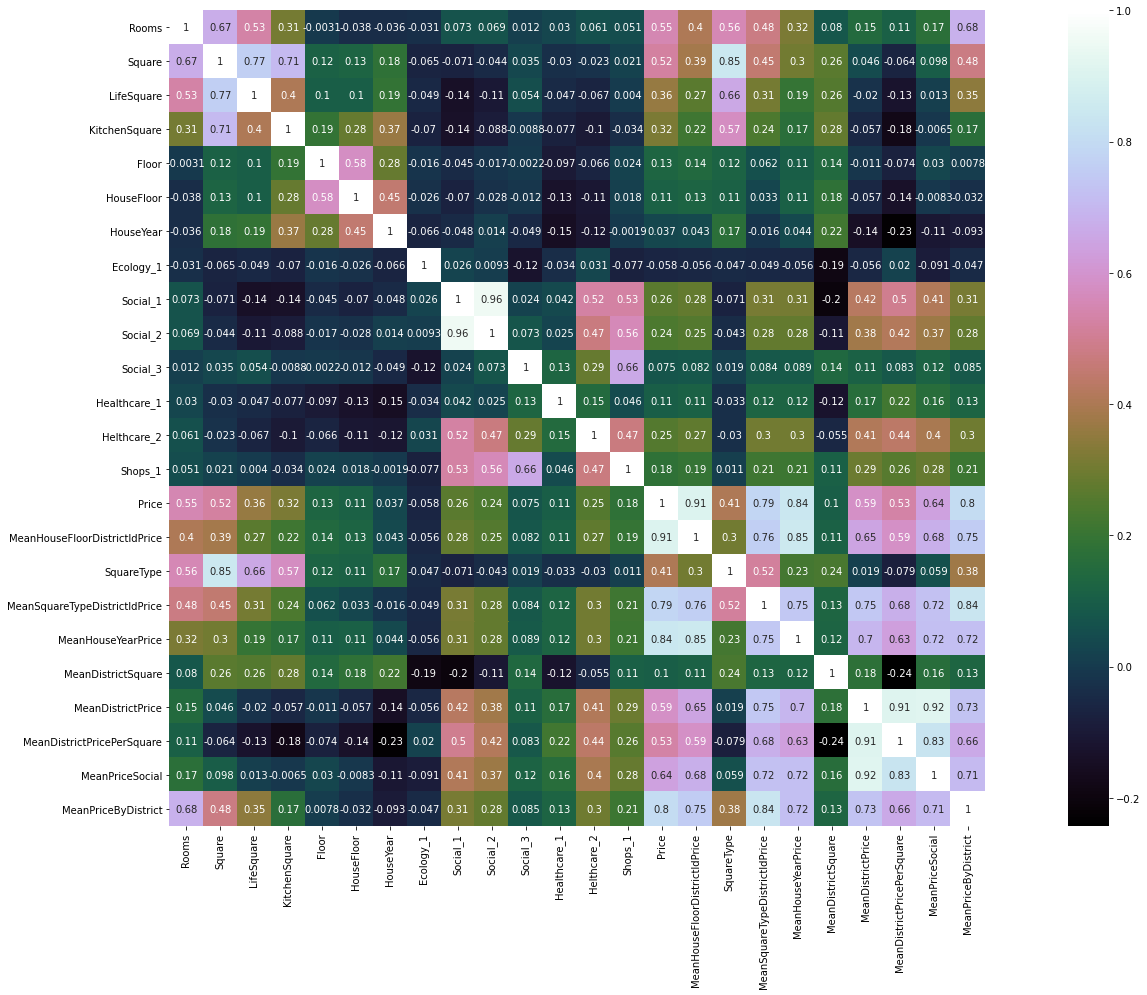

In [18]:
get_correlation_heatmap(train_data, "train_data")

### Построение корреляционной матрицы для тестовых данных

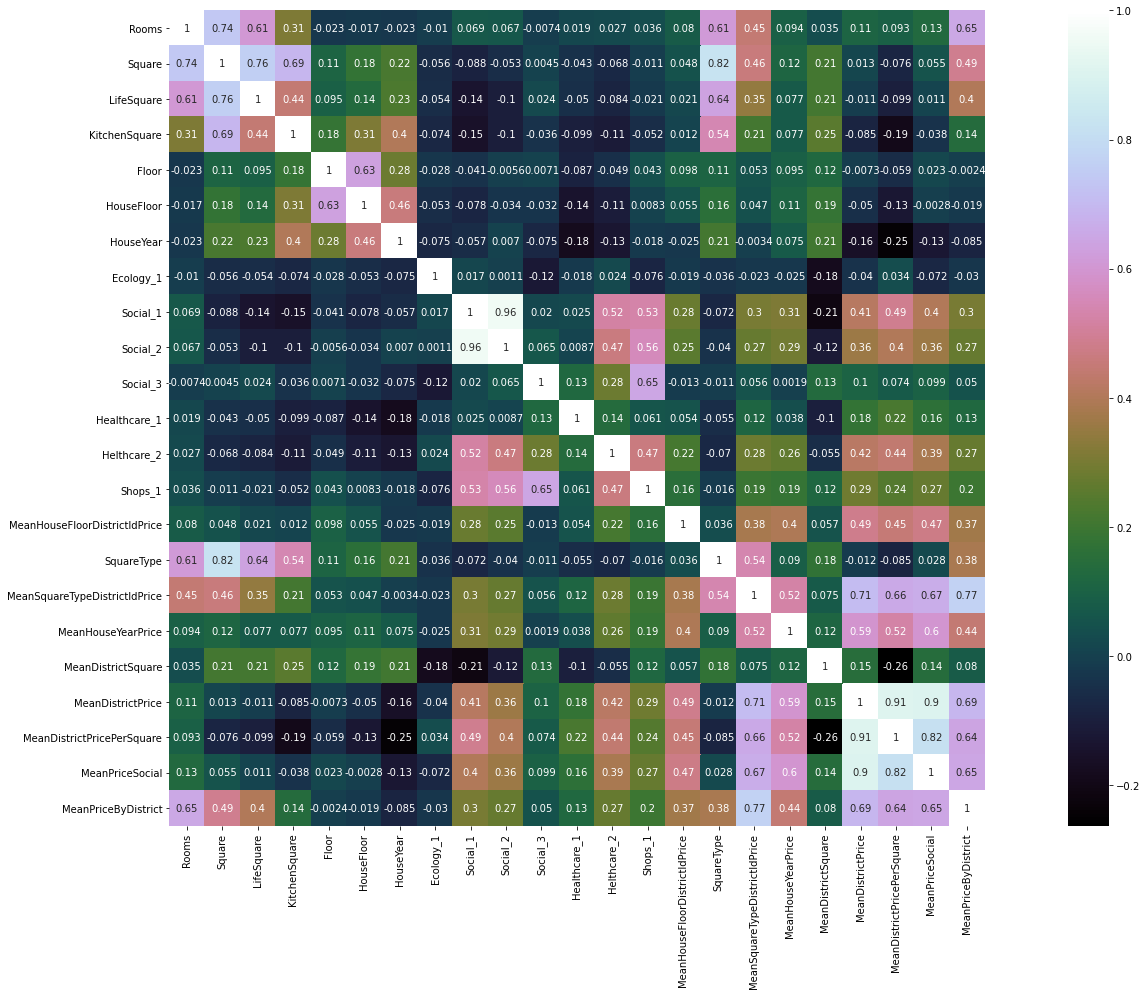

In [19]:
get_correlation_heatmap(test_data, "test_data")

## Обучение модели на тренировочных данных

In [20]:
model = estimate_gradient_boosting(train_data) 

Значение R2 для тренировочных данных:  0.9359642167741405
Значение R2 для тестовых данных:  0.9146631891050987
0.9772416217550953


## Предсказание модели для тестовых данных

In [21]:
y_pred = model.predict(test_data)
result = pd.DataFrame({"Id": saved_house_ids.to_numpy(), "Price": y_pred})
result.to_csv(r'Klimova_predictions.csv', index = False, header=True)